# Automatic Differentiation

**Motivation:**
Differentiation is a crucial step in nearly all deep learning optimization algorithms. Given the complexity of the functions we want to optimize, it is best to automate this.

In practice, the system builds a *computational graph*, tracking which data combined through which operations to produce the output.

<img src="ReverseaccumulationAD.png" alt="Drawing" style="width: 600px;"/>
<font size=1>By Berland at English Wikipedia - Transferred from en.wikipedia to Commons by JRGomà., Public Domain, <a href=https://commons.wikimedia.org/w/index.php?curid=4860887>Link</a></font>

**Automatic differentiation** enables the system to backpropagate gradients. *Backpropagate* simply means to trace through the computational graph, filling in the partial derivatives with respect to each parameter.

## A Simple Example

Example: **differentiate the function $y = 2\mathbf{x}^{\top}\mathbf{x}$ WRT the column vector $\mathbf{x}$.**

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

**We need a place to store the gradient of $y$ with respect to $\mathbf{x}$.**

In [2]:
x.requires_grad_(True)  # Same as `x = torch.arange(4.0, requires_grad=True)`
x.grad  # The default value is None

In [3]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

**We can automatically calculate the gradient of `y` with respect to each component of `x`**

In [4]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

(**The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
Let us quickly verify that our desired gradient was calculated correctly.


In [5]:
x.grad == 4 * x

tensor([True, True, True, True])

**Here's another function of `x`.**

In [6]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

The differentiation of a vector `y` with respect to a vector `x` is a matrix (see exercise)

In [7]:
# Invoking `backward` on a non-scalar requires passing in a `gradient` argument
# which specifies the gradient of the differentiated function w.r.t `self`.
# In our case, we simply want to sum the partial derivatives, so passing
# in a gradient of ones is appropriate
x.grad.zero_()
y = x * x
# y.backward(torch.ones(len(x))) equivalent to the below
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

**Move some calculations outside of the recorded computational graph.**

We can detach `y` to return a new variable `u` that has the same value as `y` but discards any information about how `y` was computed in the computational graph.

The gradient will not flow backwards through `u` to `x`.

In [8]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Since the computation of `y` was recorded,
we can subsequently invoke backpropagation on `y` to get the derivative of `y = x * x` with respect to `x`, which is `2 * x`.


In [9]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Computing the Gradient of Python Control Flow

**Even if** building the computational graph of **a function
required passing through a maze of Python control flow** we can still calculate the gradient of the resulting variable.

In [10]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Let us compute the gradient.


In [11]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

We can now analyze the `f` function defined above.
Note that it is piecewise linear in its input `a`.
In other words, for any `a` there exists some constant scalar `k`
such that `f(a) = k * a`, where the value of `k` depends on the input `a`.
Consequently `d / a` allows us to verify that the gradient is correct.


In [12]:
a.grad == d / a

tensor(True)

## Summary

* Deep learning frameworks can automate the calculation of derivatives. To use it, we first attach gradients to those variables with respect to which we desire partial derivatives. We then record the computation of our target value, execute its function for backpropagation, and access the resulting gradient.

## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or matrix. At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Redesign an example of finding the gradient of the control flow. Run and analyze the result.
1. Let $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$, where the latter is computed without exploiting that $f'(x) = \cos(x)$.

---

## Solutions

1. Why is the second derivative much more expensive to compute than the first derivative?

**Solution:**

In short, it is because there is quadratic blowup in the number of terms that must be computed. See below for an example.

<img src="Exercise_1.jpg" alt="Drawing" style="width: 600px;"/>

---

2. After running the function for backpropagation, immediately run it again and see what happens.

**Solution:**
An error occurs! The intermediate results are not persisted.

In [13]:
x = torch.arange(4.0)
x.requires_grad_(True)

tensor([0., 1., 2., 3.], requires_grad=True)

In [14]:
y = torch.dot(x, x)

In [15]:
y.backward()
x.grad

tensor([0., 2., 4., 6.])

In [16]:
y.backward()
x.grad

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

---

3. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or matrix. At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?

**Solution:**

The result would still be the same. Every dimension of the input is independent of the other dimensions of the input and therefore can all be scaled by the same constant to arrive at the gradient.

---

4. Redesign an example of finding the gradient of the control flow. Run and analyze the result.

**Solution:**

Maybe you can come up with something a little better, but here's something!

In [17]:
def g(x):
    y = x.sum()
    if y >= 10:
        z = 2*y
    else:
        z = y
    return z

In [18]:
x = torch.arange(1, 5.0)
x.requires_grad_(True)

tensor([1., 2., 3., 4.], requires_grad=True)

In [19]:
d = g(x)

In [20]:
d.backward()
x.grad

tensor([2., 2., 2., 2.])

In [21]:
if x.sum() >= 10:
    print(x.grad == 2*torch.ones((x.shape)))
else:
    print(x.grad == torch.ones((x.shape)))

tensor([True, True, True, True])


---

5. Let $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$, where the latter is computed without exploiting that $f'(x) = \cos(x)$.

**Solution:**

In [22]:
!pip install d2l

zsh:1: command not found: pip


In [23]:
from d2l.torch import plot

In [24]:
x = torch.arange(0, 8, 0.1, requires_grad=True)
torch.sin(x).backward(gradient=torch.ones(x.shape))

In [25]:
sin = torch.sin(x).detach().numpy()
cos = x.grad.detach().numpy()
x = x.detach().numpy()

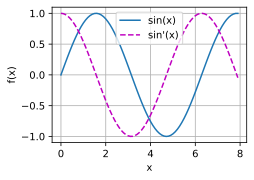

In [26]:
plot(x, [sin, cos], 'x', 'f(x)', legend=['sin(x)', 'sin\'(x)'])